In [1]:
import numpy as np
import pandas as pd
import math
import sys, os
#import seaborn as sns
#from scipy import stats
#from pathlib import Path
#import matplotlib.pyplot as plt
#from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.datasets import fetch_california_housing
#import math
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import optuna
from optuna.samplers import TPESampler
#import lightgbm as lgbm
#from xgboost import XGBRegressor
import xgboost as xgb
#from catboost import CatBoostRegressor
#from lightgbm.sklearn import LGBMRegressor
#from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
pd.set_option('display.max_columns', 500)
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from sklearn import metrics

import sys, os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import math
import pickle
import mplcyberpunk

In [2]:
from itertools import islice, cycle

plt.style.use("cyberpunk")

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

def render_feature_distros(train_df, test_df, features=[], labels=[], n_bins=50, n_cols=4, pad=2, h_pad=4, w_pad=None):
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    markers = ['.', '+', 'x', '1', '2']
    
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)
    
    # delete exess subplots
    for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
        a.axis('off')
        
    leg_handles = []
    leg_labels = []
    
    axs = []

    for i, feature in enumerate(features):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols)
        
        color_cycle = islice(mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'], 0, None)
        
        sns.histplot(train_df[feature], label='Train X', ax=ax[row, col], color=next(color_cycle)['color'], **histplot_hyperparams)
        sns.histplot(test_df[feature], label='Test X', ax=ax[row, col],color=next(color_cycle)['color'], **histplot_hyperparams)
        ax[row, col].set_title(f'{feature} Distribution')
        mplcyberpunk.make_lines_glow(ax[row, col])
        axs.append(ax[row, col].get_legend_handles_labels())

        for j, label in enumerate(labels):
            sub_ax = add_secondary_plot(train_df, feature, label, ax[row, col], n_bins, color=next(color_cycle)['color'], marker=markers[j])
            axs.append(sub_ax.get_legend_handles_labels())
        
    for axis in axs:
        if axis[1][0] not in leg_labels:
            leg_labels.extend(axis[1])
            leg_handles.extend(axis[0])
        
    fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=len(features) + 2)

In [3]:
train_time = 1 * 60 * 60
objective = 'xgbregressor'

In [4]:
sys.path.append(os.path.realpath('..'))

In [5]:
train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
sample_sub = pd.read_csv(r"..\data\sample_submission.csv", index_col=0)

In [6]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
Time,0,0.0
V16,0,0.0
Amount,0,0.0
V28,0,0.0
V27,0,0.0
V26,0,0.0
V25,0,0.0
V24,0,0.0
V23,0,0.0
V22,0,0.0


In [7]:
train_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000,219129.000000
mean,62377.415376,0.096008,0.048345,0.592102,0.069273,-0.161555,0.133688,-0.128224,0.149534,-0.048337,-0.039758,0.153632,-0.061038,0.014330,0.067649,0.108643,0.013650,0.036815,-0.033927,-0.008302,0.009708,-0.031064,-0.050852,-0.050531,-0.002992,0.124005,0.009881,0.014034,0.017313,66.359803,0.002140
std,25620.348569,1.395425,1.159805,1.132884,1.253125,1.069530,1.202411,0.817207,0.716212,1.054143,0.821889,0.976946,0.998470,1.039145,0.801335,0.891613,0.786654,0.691709,0.784454,0.739928,0.439521,0.422777,0.597812,0.318175,0.593100,0.406741,0.473867,0.233355,0.164859,150.795017,0.046214
min,0.000000,-29.807725,-44.247914,-19.722872,-5.263650,-37.591259,-25.659750,-31.179799,-28.903442,-8.756951,-22.092656,-4.190145,-16.180165,-4.373778,-15.585021,-4.155728,-11.778839,-20.756768,-7.456060,-4.281628,-18.679066,-14.689621,-8.748979,-11.958588,-2.836285,-3.958591,-1.858672,-9.234767,-4.551680,0.000000,0.000000
25%,47933.000000,-0.846135,-0.573728,-0.027154,-0.769256,-0.847346,-0.631835,-0.646730,-0.095948,-0.711444,-0.499563,-0.576969,-0.476890,-0.671601,-0.329905,-0.461596,-0.461077,-0.406675,-0.496990,-0.463035,-0.167927,-0.190418,-0.473099,-0.174478,-0.332540,-0.126080,-0.318330,-0.050983,-0.009512,5.990000,0.000000
50%,63189.000000,0.385913,0.046937,0.735895,0.064856,-0.229929,-0.087778,-0.098970,0.111219,-0.131323,-0.106034,0.090545,0.087649,-0.016837,0.049266,0.178975,0.054550,-0.013949,-0.039451,-0.002935,-0.037702,-0.042858,-0.032856,-0.063307,0.038708,0.145934,-0.086388,0.015905,0.022163,21.900000,0.000000
75%,77519.000000,1.190661,0.814145,1.306110,0.919353,0.356856,0.482388,0.385567,0.390976,0.583715,0.403967,0.917392,0.608480,0.695547,0.460837,0.791255,0.531777,0.410978,0.446448,0.455718,0.126750,0.109187,0.354910,0.060221,0.394566,0.402926,0.253869,0.076814,0.066987,68.930000,0.000000
max,120580.000000,2.430494,16.068473,6.145578,12.547997,34.581260,16.233967,39.824099,18.270586,13.423914,15.878405,9.417789,5.406614,5.976265,6.078453,4.693323,5.834992,8.845303,4.847887,4.090974,15.407839,22.062945,6.163541,12.734391,4.572739,3.111624,3.402344,13.123618,23.263746,7475.000000,1.000000


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219129 entries, 0 to 219128
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    219129 non-null  float64
 1   V1      219129 non-null  float64
 2   V2      219129 non-null  float64
 3   V3      219129 non-null  float64
 4   V4      219129 non-null  float64
 5   V5      219129 non-null  float64
 6   V6      219129 non-null  float64
 7   V7      219129 non-null  float64
 8   V8      219129 non-null  float64
 9   V9      219129 non-null  float64
 10  V10     219129 non-null  float64
 11  V11     219129 non-null  float64
 12  V12     219129 non-null  float64
 13  V13     219129 non-null  float64
 14  V14     219129 non-null  float64
 15  V15     219129 non-null  float64
 16  V16     219129 non-null  float64
 17  V17     219129 non-null  float64
 18  V18     219129 non-null  float64
 19  V19     219129 non-null  float64
 20  V20     219129 non-null  float64
 21  V21     21

In [9]:
print((train_df.isna().sum().sort_values(ascending = False)))

Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V15       0
V1        0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
Class     0
dtype: int64


In [10]:
print((test_df.isna().sum().sort_values(ascending = False)))

Time      0
V1        0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V16       0
V15       0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
Amount    0
dtype: int64


In [11]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
target = ['Class']

In [12]:
np.unique(train_df[target], return_counts=True)

(array([0, 1], dtype=int64), array([218660,    469], dtype=int64))

In [13]:
train_df[features] = train_df[features].apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())).round(2))
test_df[features] = test_df[features].apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())).round(2))

In [14]:
np.unique(train_df[target], return_counts=True)

(array([0, 1], dtype=int64), array([218660,    469], dtype=int64))

In [15]:
from itertools import islice, cycle
from cycler import cycler

plt.style.use("cyberpunk")

mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'] = cycler('color', ['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#fe00fe', '#FF5733'])

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

def render_feature_distros(train_df, test_df, features=[], labels=[], n_bins=50, n_cols=4, pad=2, h_pad=4, w_pad=None):
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    markers = ['.', '+', 'x', '1', '2']
    
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)
    
    # delete exess subplots
    for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
        a.axis('off')
        
    leg_handles = []
    leg_labels = []
    
    axs = []

    for i, feature in enumerate(features):
        print(i)
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols)
        
        color_cycle = islice(mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'], 0, None)
        
        sns.histplot(train_df[feature], label='Train X', ax=ax[row, col], color=next(color_cycle)['color'], **histplot_hyperparams)
        sns.histplot(test_df[feature], label='Test X', ax=ax[row, col],color=next(color_cycle)['color'], **histplot_hyperparams)
        ax[row, col].set_title(f'{feature} Distribution')
        mplcyberpunk.make_lines_glow(ax[row, col])
        axs.append(ax[row, col].get_legend_handles_labels())

        for j, label in enumerate(labels):
            sub_ax = add_secondary_plot(train_df, feature, label, ax[row, col], n_bins, color=next(color_cycle)['color'], marker=markers[j])
            axs.append(sub_ax.get_legend_handles_labels())
        
    for axis in axs:
        if axis[1][0] not in leg_labels:
            leg_labels.extend(axis[1])
            leg_handles.extend(axis[0])
        
    fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=len(features) + 2)

In [16]:
#render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0]])

In [17]:
scaler = MinMaxScaler().fit(train_df[features])
X = scaler.transform(train_df[features])
X_test = scaler.transform(test_df[features])

scaler = MinMaxScaler().fit(train_df[target])
Y = scaler.transform(train_df[target])

In [55]:
RANDOM_STATE = 12 
FOLDS = 5
param_grid_history = {}
best_auc = 0


def objective_v3(trial):
    global best_auc
    oof = np.zeros(len(X))
    scores = []
    param_grid = {
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'n_estimators': trial.suggest_int('n_estimators', 2, 1000, 1), 
        #'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.9),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.9),
        'eta': trial.suggest_float('eta', 0.001, 0.9), 
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 5), 
    } 
        
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
    reg = xgb.XGBModel(
    # These parameters should help with trial speed.
    objective='binary:logistic',
    tree_method='gpu_hist',
    booster='gbtree',
    predictor='gpu_predictor',
    n_jobs=4,
    eval_metric='auc',
    early_stopping_rounds=100,
    **param_grid
)
    for x in range(10):
        for fold, (train_idx, valid_idx) in enumerate(skf.split(X, Y)):
            print(10*"=", f"Fold={fold+1}", 10*"=")
            X_train, X_valid = train_df.iloc[train_idx][features], train_df.iloc[valid_idx][features]
            y_train , y_valid = train_df[target].iloc[train_idx] , train_df[target].iloc[valid_idx] 

            reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

            oof[valid_idx] = reg.predict(X_valid)

        roc_auc = roc_auc_score(Y, oof)

        if roc_auc > best_auc:
            best_auc = roc_auc
            train_final_preds = reg.predict(train_df[features])
            test_final_preds = reg.predict(test_df[features])
            train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds})
            train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)
            test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds})
            test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)
    
    param_grid_history[roc_auc] = param_grid

    return roc_auc

In [19]:
param_grid_history = {}
model

def skfold_cv(model, X, y, metric, n_folds=69):
    skfold = StratifiedKFold(n_splits=n_folds, random_state=0, shuffle=True)
    scores = []
    for train_index, test_index in skfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
        predictions = model.predict_proba(X_test.values)
        
        score = metric(y_test, predictions[:, 1])
        scores.append(score)
        print(f'ROC AUC: {score:.3f}')
    return scores

def objective_v4(trial):
    folds =10
    param_grid = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000),
        "n_estimators": trial.suggest_int('num_boost_round', 500, 2000),
        'tree_method': 'gpu_hist',
        'n_jobs': -1,
        'early_stopping_rounds': 100
    }
    model = xgb.XGBClassifier(**param_grid)
    scores = skfold_cv(model, train_df[features], train_df[target], roc_auc_score, folds)
    score = np.sum(scores)/folds
    param_grid_history[score] = param_grid
    return score

In [56]:
study = optuna.create_study(direction='maximize', sampler=TPESampler(), study_name=objective) #recommeded between 100-1000 itterations
study.optimize(objective_v3, n_trials=1000)

[I 2023-01-28 13:00:22,916] A new study created in memory with name: xgbregressor


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:01:48,030] Trial 0 finished with value: 0.6569290036990181 and parameters: {'max_depth': 8, 'n_estimators': 305, 'min_child_weight': 0.3470083025634997, 'eta': 0.010760963846981601, 'subsample': 0.9496953022954823, 'colsample_bytree': 0.15154051418046113, 'reg_lambda': 1.7603907550543094}. Best is trial 0 with value: 0.6569290036990181.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:02:27,057] Trial 1 finished with value: 0.7843352230497953 and parameters: {'max_depth': 3, 'n_estimators': 604, 'min_child_weight': 0.5020457068720324, 'eta': 0.23252850961014773, 'subsample': 0.11140635092609796, 'colsample_bytree': 0.20674832967059403, 'reg_lambda': 3.133795127944148}. Best is trial 1 with value: 0.7843352230497953.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:02:51,770] Trial 2 finished with value: 0.6572666436798512 and parameters: {'max_depth': 4, 'n_estimators': 49, 'min_child_weight': 0.19593497738640658, 'eta': 0.0598185249217105, 'subsample': 0.9850695825122576, 'colsample_bytree': 0.9135370989616146, 'reg_lambda': 1.577927688273343}. Best is trial 1 with value: 0.7843352230497953.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:03:27,104] Trial 3 finished with value: 0.7819113101568245 and parameters: {'max_depth': 5, 'n_estimators': 100, 'min_child_weight': 0.2848895747133437, 'eta': 0.28144068512053017, 'subsample': 0.39106217961093226, 'colsample_bytree': 0.8071038008619741, 'reg_lambda': 1.9289805142810224}. Best is trial 1 with value: 0.7843352230497953.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:03:47,870] Trial 4 finished with value: 0.6776309746299275 and parameters: {'max_depth': 8, 'n_estimators': 7, 'min_child_weight': 0.19654528683990483, 'eta': 0.3174146202708281, 'subsample': 0.4420345032813702, 'colsample_bytree': 0.8190684174756956, 'reg_lambda': 2.8693776610403603}. Best is trial 1 with value: 0.7843352230497953.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:04:12,040] Trial 5 finished with value: 0.7705556055033401 and parameters: {'max_depth': 7, 'n_estimators': 26, 'min_child_weight': 0.654407782996185, 'eta': 0.8453017795337139, 'subsample': 0.28923486586370617, 'colsample_bytree': 0.9027456709999477, 'reg_lambda': 3.9113750484450276}. Best is trial 1 with value: 0.7843352230497953.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:05:08,334] Trial 6 finished with value: 0.7999059936106274 and parameters: {'max_depth': 6, 'n_estimators': 274, 'min_child_weight': 0.6094211714525285, 'eta': 0.2687181410720611, 'subsample': 0.5818931080313665, 'colsample_bytree': 0.11832678903807993, 'reg_lambda': 4.999085854342626}. Best is trial 6 with value: 0.7999059936106274.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:05:56,915] Trial 7 finished with value: 0.7383794480316921 and parameters: {'max_depth': 7, 'n_estimators': 677, 'min_child_weight': 0.1646437353351341, 'eta': 0.7711324114759929, 'subsample': 0.814097866545468, 'colsample_bytree': 0.7543569625706709, 'reg_lambda': 1.5320382648427304}. Best is trial 6 with value: 0.7999059936106274.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:06:42,468] Trial 8 finished with value: 0.743860101954588 and parameters: {'max_depth': 7, 'n_estimators': 505, 'min_child_weight': 0.17190841353383368, 'eta': 0.5703528725778388, 'subsample': 0.1674238253985103, 'colsample_bytree': 0.8631648239901326, 'reg_lambda': 4.013978462800764}. Best is trial 6 with value: 0.7999059936106274.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:07:24,085] Trial 9 finished with value: 0.8163738594271719 and parameters: {'max_depth': 5, 'n_estimators': 408, 'min_child_weight': 0.5033216065994416, 'eta': 0.2784913545484563, 'subsample': 0.9796653244429526, 'colsample_bytree': 0.4978063919386898, 'reg_lambda': 3.909603718838961}. Best is trial 9 with value: 0.8163738594271719.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:08:02,541] Trial 10 finished with value: 0.7984312376001375 and parameters: {'max_depth': 5, 'n_estimators': 971, 'min_child_weight': 0.8439655986129537, 'eta': 0.5565360726715005, 'subsample': 0.7186606499659878, 'colsample_bytree': 0.44265548274042704, 'reg_lambda': 4.812448911053916}. Best is trial 9 with value: 0.8163738594271719.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:08:48,277] Trial 11 finished with value: 0.7909108727182449 and parameters: {'max_depth': 6, 'n_estimators': 310, 'min_child_weight': 0.5624750437227303, 'eta': 0.40171445774866854, 'subsample': 0.6407091104041742, 'colsample_bytree': 0.3752029532642049, 'reg_lambda': 4.869181891785746}. Best is trial 9 with value: 0.8163738594271719.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:09:45,113] Trial 12 finished with value: 0.7984007553665211 and parameters: {'max_depth': 6, 'n_estimators': 322, 'min_child_weight': 0.7165731895613997, 'eta': 0.16701102968530906, 'subsample': 0.5458934882204113, 'colsample_bytree': 0.623986511844744, 'reg_lambda': 4.173694206250103}. Best is trial 9 with value: 0.8163738594271719.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:10:21,086] Trial 13 finished with value: 0.7966748475937075 and parameters: {'max_depth': 4, 'n_estimators': 246, 'min_child_weight': 0.4053695719539503, 'eta': 0.46707161711225864, 'subsample': 0.8425547279695342, 'colsample_bytree': 0.3016402906572332, 'reg_lambda': 3.4927568481334266}. Best is trial 9 with value: 0.8163738594271719.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:11:08,986] Trial 14 finished with value: 0.7946709673984418 and parameters: {'max_depth': 5, 'n_estimators': 449, 'min_child_weight': 0.021335437673848545, 'eta': 0.15008583707282042, 'subsample': 0.5922532182983224, 'colsample_bytree': 0.5455714540615367, 'reg_lambda': 4.605540723216677}. Best is trial 9 with value: 0.8163738594271719.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:11:45,281] Trial 15 finished with value: 0.7909366256225894 and parameters: {'max_depth': 4, 'n_estimators': 206, 'min_child_weight': 0.6047665719536437, 'eta': 0.3799525224807412, 'subsample': 0.7850319456704329, 'colsample_bytree': 0.6431989149334125, 'reg_lambda': 2.38460721624169}. Best is trial 9 with value: 0.8163738594271719.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:12:28,708] Trial 16 finished with value: 0.7668735008757547 and parameters: {'max_depth': 6, 'n_estimators': 432, 'min_child_weight': 0.7723585134038751, 'eta': 0.5362688700721008, 'subsample': 0.4736114661818793, 'colsample_bytree': 0.26605804795706056, 'reg_lambda': 4.459556743319314}. Best is trial 9 with value: 0.8163738594271719.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[I 2023-01-28 13:13:14,681] Trial 17 finished with value: 0.8062708224566886 and parameters: {'max_depth': 3, 'n_estimators': 730, 'min_child_weight': 0.527402445255067, 'eta': 0.14330383690159457, 'subsample': 0.9070938459421166, 'colsample_bytree': 0.10090835529090725, 'reg_lambda': 3.5919571668955044}. Best is trial 9 with value: 0.8163738594271719.


========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fold=5 ==========
========== Fold=1 ==========
========== Fold=2 ==========
========== Fold=3 ==========
========== Fold=4 ==========
========== Fol

[W 2023-01-28 13:13:55,678] Trial 18 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "D:\source\repos\venv\Python310\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ryans\AppData\Local\Temp\ipykernel_13388\856456090.py", line 40, in objective_v3
    reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
  File "D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "D:\source\repos\venv\Python310\lib\site-packages\xgboost\sklearn.py", line 1025, in fit
    self._Booster = train(
  File "D:\source\repos\venv\Python310\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "D:\source\repos\venv\Python310\lib\site-packages\xgboost\training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "D:\source\repos\venv\Python310\lib\site-packages

KeyboardInterrupt: 

In [53]:
model.feature_importances_.shape

(29,)

In [52]:
train_df[features].columns.shape

(29,)

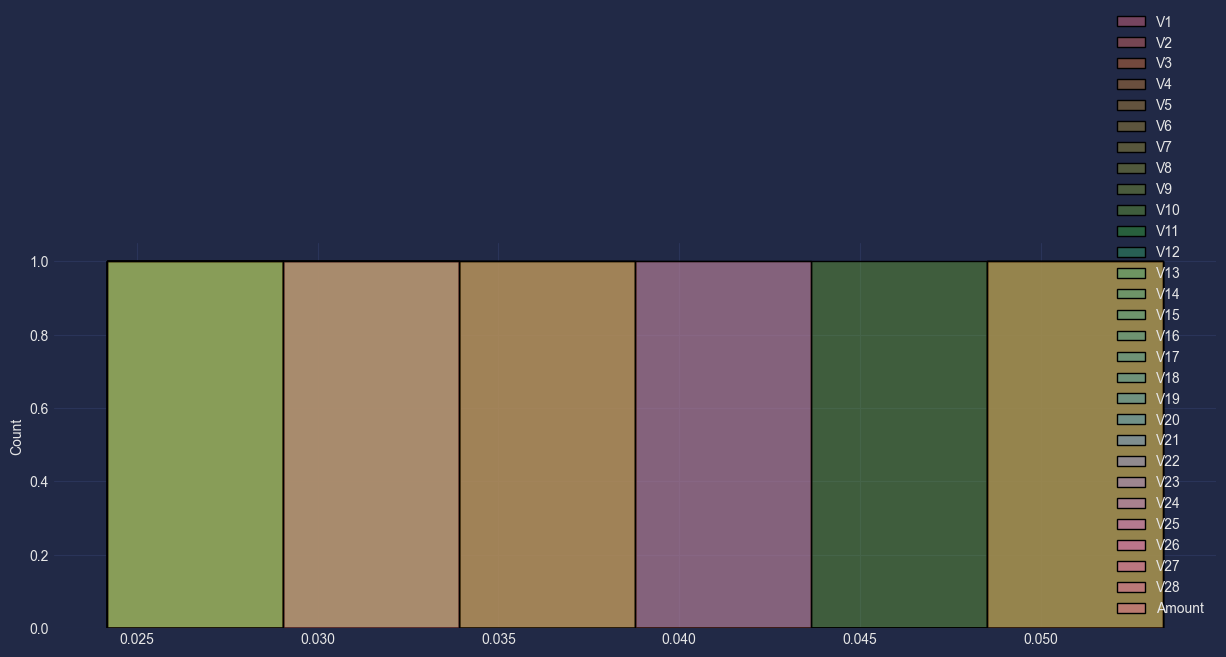

In [54]:
plt.style.use("cyberpunk")

histplot_hyperparams = {
        'alpha':0.4,
        #'stat':'percent',
        #'bins':100
        'kde':True,
    }

n_cols = 1
n_rows = 1
cell_with_dim = 15
cell_height_dim = 5

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
sns.histplot(fi_df, ax=ax, **histplot_hyperparams)
#sns.histplot(train_df[target], ax=ax, **histplot_hyperparams)

mplcyberpunk.make_lines_glow(ax)
plt.show()

In [23]:
plot_feature_importance(xgb_model.feature_importances_,X_train.columns,'XGB ', max_features = 35)

NameError: name 'plot_feature_importance' is not defined

In [ ]:
parm_grid_bytes = pickle.dumps(param_grid_history)
with open(f"rendered_data/{objective}_bytes.hex", "wb") as binary_file:
    binary_file.write(parm_grid_bytes)

In [22]:
def train(param_grid):
    reg = xgb.XGBModel(
        # These parameters should help with trial speed.
        objective='binary:logistic',
        booster='gbtree',
        predictor='gpu_predictor',
        eval_metric='auc',
        **param_grid
    )
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.20)
    
    reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        
    return reg

percent = math.ceil(len(param_grid_history.keys()) * .1)
top = sorted(list(param_grid_history.keys()))[-1:]

train_preds = []
test_preds = []
for key in tqdm(top):
    model = train(param_grid_history[key])
    train_preds.append(model.predict(train_df[features]))
    test_preds.append(model.predict(test_df[features]))

train_final_preds = np.stack(train_preds).mean(0)
test_final_preds = np.stack(test_preds).mean(0)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]


In [ ]:
plt.style.use("cyberpunk")

histplot_hyperparams = {
        'alpha':0.4,
        'stat':'percent',
        'bins':100
    }

n_cols = 1
n_rows = 1
cell_with_dim = 6
cell_height_dim = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

sns.histplot(train_final_preds, ax=ax, **histplot_hyperparams)
#sns.histplot(train_df[target], ax=ax, **histplot_hyperparams)

mplcyberpunk.make_lines_glow(ax)
print(np.unique(train_final_preds, return_counts=True))
print(roc_auc_score(train_df[target], train_final_preds))
plt.show()

In [ ]:
sns.boxplot(train_final_preds)

In [ ]:
plt.style.use("cyberpunk")

histplot_hyperparams = {
        'alpha':0.4,
        'stat':'percent',
        'bins':100
    }

n_cols = 1
n_rows = 1
cell_with_dim = 6
cell_height_dim = 3

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

sns.histplot(train_df[target], ax=ax, **histplot_hyperparams)

mplcyberpunk.make_lines_glow(ax)

plt.show()

In [ ]:
train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds})
train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)

test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds})
test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)